In [10]:
from PIL import Image
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import utils
from tqdm import tqdm
import warnings
import torchvision.models as models

warnings.simplefilter('ignore', Image.DecompressionBombWarning)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt

In [2]:
lr = 5e-4
n_epochs = 100
training_path = "/DAS_Storage4/hyungseok/Training"
validation_path = "/DAS_Storage4/hyungseok/Validation"


In [3]:
device = torch.device("cuda:4")

In [4]:
train_trans = transforms.Compose([transforms.Resize((128,128)),
                           transforms.ToTensor(),     
                           transforms.RandomHorizontalFlip(),
                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                           ])
valid_trans = transforms.Compose([transforms.Resize((128,128)),
                           transforms.ToTensor(),                           
                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                           ])
trainset = torchvision.datasets.ImageFolder(root = training_path,
                                           transform = train_trans)
validset = torchvision.datasets.ImageFolder(root = validation_path,
                                           transform = valid_trans)
train_loader = DataLoader(trainset, batch_size = 256, shuffle = True, num_workers = 4)
valid_loader = DataLoader(validset, batch_size = 256, shuffle = False, num_workers = 4)

In [5]:
model = models.vgg19(pretrained=False)

In [6]:
model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),                               
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),                                 
                                 nn.Linear(4096,128)
                                 
                                )

In [7]:
model = model.to(device)
utils.init_weights(model, init_type='uniform')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (0.9, 0.98), eps = 1e-9, weight_decay = 1e-5)

In [8]:
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

for epoch in range(n_epochs):
    
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    running_val_loss = 0.0
    valid_correct = 0
    valid_total = 0
    model.train()
    
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        output = model(x)
        
        loss = criterion(output, y)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(output.data, 1)
        train_total += y.size(0)
        train_correct += (predicted == y).sum().item()
        
    with torch.no_grad():
        model.eval()

        for idx, (x, y) in tqdm(enumerate(valid_loader)):

            x, y = x.to(device), y.to(device)

            valid_output = model(x)

            valid_loss = criterion(valid_output, y)

            running_val_loss += valid_loss.item()

            _, predicted = torch.max(valid_output.data, 1)
            valid_total += y.size(0)
            valid_correct += (predicted == y).sum().item()
            
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : loss
    }, 'model/vgg/{}-vgg_model.pt'.format(epoch+1))


            
        
    print('Epoch {}/{}, Train_Acc: {:.3f}, Train_Loss : {:.6f}, valid_Acc : {:.3f}, Valid_Loss : {:.6f}'.format(epoch+1,n_epochs, 
                                                                                                              train_correct/train_total,
                                                                                                              running_loss / len(train_loader),
                                                                                                             valid_correct/valid_total,
                                                                                                              running_val_loss / len(valid_loader)
                                                                                                             ))
    
    train_loss_list.append(running_loss / len(train_loader))
    valid_loss_list.append(running_val_loss / len(valid_loader))
    train_acc_list.append(train_correct/train_total)
    valid_acc_list.append(valid_correct/valid_total)
    
        

2072it [1:36:59,  2.81s/it]
259it [12:05,  2.80s/it]


Epoch 1/100, Train_Acc: 0.140, Train_Loss : 18.045198, valid_Acc : 0.292, Valid_Loss : 2.954472


2072it [1:35:46,  2.77s/it]
259it [11:59,  2.78s/it]


Epoch 2/100, Train_Acc: 0.383, Train_Loss : 2.486566, valid_Acc : 0.484, Valid_Loss : 2.002283


2072it [1:36:16,  2.79s/it]
259it [12:19,  2.86s/it]


Epoch 3/100, Train_Acc: 0.515, Train_Loss : 1.855483, valid_Acc : 0.593, Valid_Loss : 1.531581


2072it [1:36:04,  2.78s/it]
259it [12:02,  2.79s/it]


Epoch 4/100, Train_Acc: 0.589, Train_Loss : 1.531650, valid_Acc : 0.643, Valid_Loss : 1.324131


2072it [1:36:03,  2.78s/it]
259it [11:57,  2.77s/it]


Epoch 5/100, Train_Acc: 0.638, Train_Loss : 1.333230, valid_Acc : 0.665, Valid_Loss : 1.235159


2072it [1:35:23,  2.76s/it]
259it [12:30,  2.90s/it]


Epoch 6/100, Train_Acc: 0.669, Train_Loss : 1.208577, valid_Acc : 0.699, Valid_Loss : 1.114254


2072it [1:36:32,  2.80s/it]
259it [13:36,  3.15s/it]


Epoch 7/100, Train_Acc: 0.689, Train_Loss : 1.124731, valid_Acc : 0.719, Valid_Loss : 1.018813


2072it [1:38:45,  2.86s/it]
259it [12:47,  2.96s/it]


Epoch 8/100, Train_Acc: 0.704, Train_Loss : 1.066593, valid_Acc : 0.732, Valid_Loss : 0.969504


2072it [1:38:11,  2.84s/it]
259it [12:43,  2.95s/it]


Epoch 9/100, Train_Acc: 0.716, Train_Loss : 1.024067, valid_Acc : 0.728, Valid_Loss : 0.987469


2072it [1:38:10,  2.84s/it]
259it [12:08,  2.81s/it]


Epoch 10/100, Train_Acc: 0.724, Train_Loss : 0.991680, valid_Acc : 0.740, Valid_Loss : 0.931615


2072it [1:40:32,  2.91s/it]
259it [14:06,  3.27s/it]


Epoch 11/100, Train_Acc: 0.729, Train_Loss : 0.974526, valid_Acc : 0.745, Valid_Loss : 0.915495


2072it [1:42:12,  2.96s/it]
259it [12:33,  2.91s/it]


Epoch 12/100, Train_Acc: 0.735, Train_Loss : 0.954567, valid_Acc : 0.757, Valid_Loss : 0.876253


2072it [1:40:23,  2.91s/it]
259it [12:08,  2.81s/it]


Epoch 13/100, Train_Acc: 0.736, Train_Loss : 0.944399, valid_Acc : 0.747, Valid_Loss : 0.909228


2072it [1:38:41,  2.86s/it]
259it [12:30,  2.90s/it]


Epoch 14/100, Train_Acc: 0.739, Train_Loss : 0.934755, valid_Acc : 0.759, Valid_Loss : 0.863143


2072it [1:36:54,  2.81s/it]
259it [13:46,  3.19s/it]


Epoch 15/100, Train_Acc: 0.742, Train_Loss : 0.927112, valid_Acc : 0.765, Valid_Loss : 0.850929


2072it [1:38:57,  2.87s/it]
259it [12:41,  2.94s/it]


Epoch 16/100, Train_Acc: 0.743, Train_Loss : 0.923977, valid_Acc : 0.766, Valid_Loss : 0.848870


2072it [1:38:38,  2.86s/it]
259it [12:27,  2.89s/it]


Epoch 17/100, Train_Acc: 0.742, Train_Loss : 0.925637, valid_Acc : 0.768, Valid_Loss : 0.836537


2072it [1:38:29,  2.85s/it]
259it [12:24,  2.88s/it]


Epoch 18/100, Train_Acc: 0.743, Train_Loss : 0.927500, valid_Acc : 0.763, Valid_Loss : 0.868923


2072it [1:38:50,  2.86s/it]
259it [12:29,  2.90s/it]


Epoch 19/100, Train_Acc: 0.743, Train_Loss : 0.930265, valid_Acc : 0.757, Valid_Loss : 0.880535


2072it [1:38:46,  2.86s/it]
259it [12:55,  3.00s/it]


Epoch 20/100, Train_Acc: 0.743, Train_Loss : 0.928842, valid_Acc : 0.752, Valid_Loss : 0.899084


2072it [1:42:41,  2.97s/it]
259it [12:51,  2.98s/it]


Epoch 21/100, Train_Acc: 0.742, Train_Loss : 0.932190, valid_Acc : 0.759, Valid_Loss : 0.881201


2072it [1:41:31,  2.94s/it]
259it [13:44,  3.18s/it]


Epoch 22/100, Train_Acc: 0.743, Train_Loss : 0.930844, valid_Acc : 0.754, Valid_Loss : 0.895826


2072it [1:44:02,  3.01s/it]
259it [12:16,  2.84s/it]


Epoch 23/100, Train_Acc: 0.742, Train_Loss : 0.933087, valid_Acc : 0.755, Valid_Loss : 0.886799


2072it [1:38:21,  2.85s/it]
259it [12:27,  2.89s/it]


Epoch 24/100, Train_Acc: 0.742, Train_Loss : 0.931921, valid_Acc : 0.762, Valid_Loss : 0.878739


2072it [1:36:27,  2.79s/it]
259it [14:30,  3.36s/it]


Epoch 25/100, Train_Acc: 0.742, Train_Loss : 0.937727, valid_Acc : 0.766, Valid_Loss : 0.844897


2072it [1:37:48,  2.83s/it]
259it [12:44,  2.95s/it]


Epoch 26/100, Train_Acc: 0.740, Train_Loss : 0.943375, valid_Acc : 0.761, Valid_Loss : 0.866205


2072it [1:37:39,  2.83s/it]
259it [12:23,  2.87s/it]


Epoch 27/100, Train_Acc: 0.738, Train_Loss : 0.945747, valid_Acc : 0.766, Valid_Loss : 0.852390


2072it [1:36:33,  2.80s/it]
259it [14:33,  3.37s/it]


Epoch 28/100, Train_Acc: 0.739, Train_Loss : 0.946978, valid_Acc : 0.765, Valid_Loss : 0.852670


2072it [1:37:32,  2.82s/it]
259it [12:26,  2.88s/it]


Epoch 29/100, Train_Acc: 0.740, Train_Loss : 0.944891, valid_Acc : 0.755, Valid_Loss : 0.898864


2072it [1:37:00,  2.81s/it]
259it [13:03,  3.02s/it]


Epoch 30/100, Train_Acc: 0.737, Train_Loss : 0.952958, valid_Acc : 0.759, Valid_Loss : 0.864745


2072it [1:38:46,  2.86s/it]
259it [14:10,  3.28s/it]


Epoch 31/100, Train_Acc: 0.738, Train_Loss : 0.954166, valid_Acc : 0.761, Valid_Loss : 0.865920


2072it [1:37:29,  2.82s/it]
259it [12:59,  3.01s/it]


Epoch 32/100, Train_Acc: 0.736, Train_Loss : 0.963269, valid_Acc : 0.757, Valid_Loss : 0.893056


2072it [1:36:10,  2.78s/it]
259it [13:44,  3.18s/it]


Epoch 33/100, Train_Acc: 0.732, Train_Loss : 0.975366, valid_Acc : 0.761, Valid_Loss : 0.873522


2072it [1:37:24,  2.82s/it]
259it [12:56,  3.00s/it]


Epoch 34/100, Train_Acc: 0.734, Train_Loss : 0.971159, valid_Acc : 0.758, Valid_Loss : 0.878213


2072it [1:36:43,  2.80s/it]
259it [14:02,  3.25s/it]


Epoch 35/100, Train_Acc: 0.734, Train_Loss : 0.971418, valid_Acc : 0.759, Valid_Loss : 0.889522


2072it [1:37:05,  2.81s/it]
259it [13:02,  3.02s/it]


Epoch 36/100, Train_Acc: 0.731, Train_Loss : 0.978581, valid_Acc : 0.753, Valid_Loss : 0.893146


2072it [1:36:07,  2.78s/it]
259it [14:05,  3.27s/it]


Epoch 37/100, Train_Acc: 0.733, Train_Loss : 0.973661, valid_Acc : 0.749, Valid_Loss : 0.922024


2072it [1:36:39,  2.80s/it]
259it [13:07,  3.04s/it]


Epoch 38/100, Train_Acc: 0.733, Train_Loss : 0.977192, valid_Acc : 0.755, Valid_Loss : 0.895195


2072it [1:36:25,  2.79s/it]
259it [13:33,  3.14s/it]


Epoch 39/100, Train_Acc: 0.734, Train_Loss : 0.975326, valid_Acc : 0.759, Valid_Loss : 0.877771


2072it [1:37:05,  2.81s/it]
259it [13:20,  3.09s/it]


Epoch 40/100, Train_Acc: 0.731, Train_Loss : 0.985419, valid_Acc : 0.748, Valid_Loss : 0.915588


2072it [1:36:49,  2.80s/it]
259it [13:32,  3.14s/it]


Epoch 41/100, Train_Acc: 0.730, Train_Loss : 0.990449, valid_Acc : 0.753, Valid_Loss : 0.911413


2072it [1:38:16,  2.85s/it]
259it [12:59,  3.01s/it]


Epoch 42/100, Train_Acc: 0.730, Train_Loss : 0.986201, valid_Acc : 0.762, Valid_Loss : 0.865845


2072it [1:36:45,  2.80s/it]
259it [13:27,  3.12s/it]


Epoch 43/100, Train_Acc: 0.730, Train_Loss : 0.992976, valid_Acc : 0.754, Valid_Loss : 0.903886


2072it [1:36:47,  2.80s/it]
259it [13:14,  3.07s/it]


Epoch 44/100, Train_Acc: 0.729, Train_Loss : 0.994852, valid_Acc : 0.756, Valid_Loss : 0.886706


2072it [1:37:31,  2.82s/it]
259it [13:21,  3.10s/it]


Epoch 45/100, Train_Acc: 0.729, Train_Loss : 0.993902, valid_Acc : 0.745, Valid_Loss : 0.939435


2072it [1:36:56,  2.81s/it]
259it [13:06,  3.04s/it]


Epoch 46/100, Train_Acc: 0.727, Train_Loss : 1.004141, valid_Acc : 0.746, Valid_Loss : 0.939200


2072it [1:37:06,  2.81s/it]
259it [13:21,  3.09s/it]


Epoch 47/100, Train_Acc: 0.727, Train_Loss : 1.000804, valid_Acc : 0.758, Valid_Loss : 0.872512


2072it [1:37:33,  2.83s/it]
259it [12:43,  2.95s/it]


Epoch 48/100, Train_Acc: 0.729, Train_Loss : 0.995788, valid_Acc : 0.741, Valid_Loss : 0.960560


2072it [1:36:17,  2.79s/it]
259it [13:23,  3.10s/it]


Epoch 49/100, Train_Acc: 0.727, Train_Loss : 1.005696, valid_Acc : 0.752, Valid_Loss : 0.908547


2072it [1:37:47,  2.83s/it]
259it [12:55,  2.99s/it]


Epoch 50/100, Train_Acc: 0.730, Train_Loss : 0.991005, valid_Acc : 0.756, Valid_Loss : 0.889014


2072it [1:36:42,  2.80s/it]
259it [13:31,  3.13s/it]


Epoch 51/100, Train_Acc: 0.730, Train_Loss : 0.990570, valid_Acc : 0.759, Valid_Loss : 0.882724


2072it [1:37:08,  2.81s/it]
259it [13:04,  3.03s/it]


Epoch 52/100, Train_Acc: 0.729, Train_Loss : 0.990808, valid_Acc : 0.757, Valid_Loss : 0.896009


2072it [1:36:55,  2.81s/it]
259it [13:14,  3.07s/it]


Epoch 53/100, Train_Acc: 0.730, Train_Loss : 0.986809, valid_Acc : 0.761, Valid_Loss : 0.875041


2072it [1:37:02,  2.81s/it]
259it [13:16,  3.07s/it]


Epoch 54/100, Train_Acc: 0.728, Train_Loss : 0.998663, valid_Acc : 0.757, Valid_Loss : 0.889613


2072it [1:36:39,  2.80s/it]
259it [13:24,  3.11s/it]


Epoch 55/100, Train_Acc: 0.727, Train_Loss : 1.001221, valid_Acc : 0.751, Valid_Loss : 0.910445


2072it [1:36:57,  2.81s/it]
259it [13:06,  3.04s/it]


Epoch 56/100, Train_Acc: 0.727, Train_Loss : 1.004324, valid_Acc : 0.753, Valid_Loss : 0.918943


2072it [1:37:01,  2.81s/it]
259it [13:11,  3.06s/it]


Epoch 57/100, Train_Acc: 0.729, Train_Loss : 0.994978, valid_Acc : 0.744, Valid_Loss : 0.944337


2072it [1:37:58,  2.84s/it]
259it [13:05,  3.03s/it]


Epoch 58/100, Train_Acc: 0.729, Train_Loss : 0.996285, valid_Acc : 0.747, Valid_Loss : 0.933211


2072it [1:37:13,  2.82s/it]
259it [12:10,  2.82s/it]


Epoch 59/100, Train_Acc: 0.728, Train_Loss : 1.002229, valid_Acc : 0.754, Valid_Loss : 0.918429


2072it [1:36:05,  2.78s/it]
259it [12:27,  2.89s/it]


Epoch 60/100, Train_Acc: 0.728, Train_Loss : 1.002013, valid_Acc : 0.743, Valid_Loss : 0.942688


2072it [1:35:59,  2.78s/it]
259it [13:32,  3.14s/it]


Epoch 61/100, Train_Acc: 0.729, Train_Loss : 0.995841, valid_Acc : 0.752, Valid_Loss : 0.906792


2072it [1:38:52,  2.86s/it]
259it [12:11,  2.82s/it]


Epoch 62/100, Train_Acc: 0.729, Train_Loss : 0.997198, valid_Acc : 0.751, Valid_Loss : 0.922633


2072it [1:36:27,  2.79s/it]
259it [12:32,  2.91s/it]


Epoch 63/100, Train_Acc: 0.728, Train_Loss : 0.999898, valid_Acc : 0.750, Valid_Loss : 0.914793


2072it [1:36:03,  2.78s/it]
259it [13:12,  3.06s/it]


Epoch 64/100, Train_Acc: 0.728, Train_Loss : 0.997032, valid_Acc : 0.759, Valid_Loss : 0.878867


2072it [1:36:01,  2.78s/it]
259it [12:30,  2.90s/it]


Epoch 65/100, Train_Acc: 0.729, Train_Loss : 0.996724, valid_Acc : 0.751, Valid_Loss : 0.919441


2072it [1:37:00,  2.81s/it]
259it [12:28,  2.89s/it]


Epoch 66/100, Train_Acc: 0.729, Train_Loss : 0.997729, valid_Acc : 0.757, Valid_Loss : 0.895634


2072it [1:36:49,  2.80s/it]
259it [12:29,  2.90s/it]


Epoch 67/100, Train_Acc: 0.729, Train_Loss : 0.996255, valid_Acc : 0.757, Valid_Loss : 0.879364


2072it [1:35:48,  2.77s/it]
259it [12:28,  2.89s/it]


Epoch 68/100, Train_Acc: 0.729, Train_Loss : 0.996659, valid_Acc : 0.756, Valid_Loss : 0.895847


2072it [1:36:38,  2.80s/it]
259it [12:16,  2.84s/it]


Epoch 69/100, Train_Acc: 0.730, Train_Loss : 0.992945, valid_Acc : 0.748, Valid_Loss : 0.924372


2072it [1:36:32,  2.80s/it]
259it [12:47,  2.96s/it]


Epoch 70/100, Train_Acc: 0.730, Train_Loss : 0.995016, valid_Acc : 0.753, Valid_Loss : 0.904283


2072it [1:35:52,  2.78s/it]
259it [12:19,  2.86s/it]


Epoch 71/100, Train_Acc: 0.730, Train_Loss : 0.993608, valid_Acc : 0.754, Valid_Loss : 0.910834


2072it [1:36:12,  2.79s/it]
259it [12:52,  2.98s/it]


Epoch 72/100, Train_Acc: 0.732, Train_Loss : 0.980964, valid_Acc : 0.751, Valid_Loss : 0.915668


2072it [1:37:35,  2.83s/it]
259it [13:23,  3.10s/it]


Epoch 73/100, Train_Acc: 0.732, Train_Loss : 0.985553, valid_Acc : 0.755, Valid_Loss : 0.894142


2072it [1:37:57,  2.84s/it]
259it [13:27,  3.12s/it]


Epoch 74/100, Train_Acc: 0.732, Train_Loss : 0.986586, valid_Acc : 0.748, Valid_Loss : 0.925043


2072it [1:37:18,  2.82s/it]
259it [12:41,  2.94s/it]


Epoch 75/100, Train_Acc: 0.734, Train_Loss : 0.977228, valid_Acc : 0.757, Valid_Loss : 0.893264


2072it [1:54:23,  3.31s/it]
259it [12:34,  2.91s/it]


Epoch 76/100, Train_Acc: 0.733, Train_Loss : 0.980080, valid_Acc : 0.744, Valid_Loss : 0.934263


2072it [1:40:05,  2.90s/it]
259it [12:35,  2.92s/it]


Epoch 77/100, Train_Acc: 0.735, Train_Loss : 0.975692, valid_Acc : 0.748, Valid_Loss : 0.935483


2072it [1:40:16,  2.90s/it]
259it [13:24,  3.11s/it]


Epoch 78/100, Train_Acc: 0.734, Train_Loss : 0.980154, valid_Acc : 0.751, Valid_Loss : 0.913094


2072it [1:38:09,  2.84s/it]
259it [12:38,  2.93s/it]


Epoch 79/100, Train_Acc: 0.734, Train_Loss : 0.975481, valid_Acc : 0.753, Valid_Loss : 0.895941


2072it [1:38:10,  2.84s/it]
259it [13:03,  3.02s/it]


Epoch 80/100, Train_Acc: 0.736, Train_Loss : 0.968603, valid_Acc : 0.766, Valid_Loss : 0.855318


2072it [1:37:43,  2.83s/it]
259it [12:59,  3.01s/it]


Epoch 81/100, Train_Acc: 0.735, Train_Loss : 0.974404, valid_Acc : 0.760, Valid_Loss : 0.881753


2072it [1:37:25,  2.82s/it]
259it [12:16,  2.84s/it]


Epoch 82/100, Train_Acc: 0.735, Train_Loss : 0.974693, valid_Acc : 0.758, Valid_Loss : 0.878845


2072it [1:37:55,  2.84s/it]
259it [13:25,  3.11s/it]


Epoch 83/100, Train_Acc: 0.736, Train_Loss : 0.970167, valid_Acc : 0.764, Valid_Loss : 0.864719


2072it [1:36:56,  2.81s/it]
259it [12:32,  2.91s/it]


Epoch 84/100, Train_Acc: 0.737, Train_Loss : 0.961808, valid_Acc : 0.758, Valid_Loss : 0.874723


2072it [1:38:15,  2.85s/it]
259it [13:10,  3.05s/it]


Epoch 85/100, Train_Acc: 0.739, Train_Loss : 0.959060, valid_Acc : 0.756, Valid_Loss : 0.903310


2072it [1:38:13,  2.84s/it]
259it [13:17,  3.08s/it]


Epoch 86/100, Train_Acc: 0.740, Train_Loss : 0.953355, valid_Acc : 0.752, Valid_Loss : 0.917645


1915it [1:34:17,  2.95s/it]


KeyboardInterrupt: 

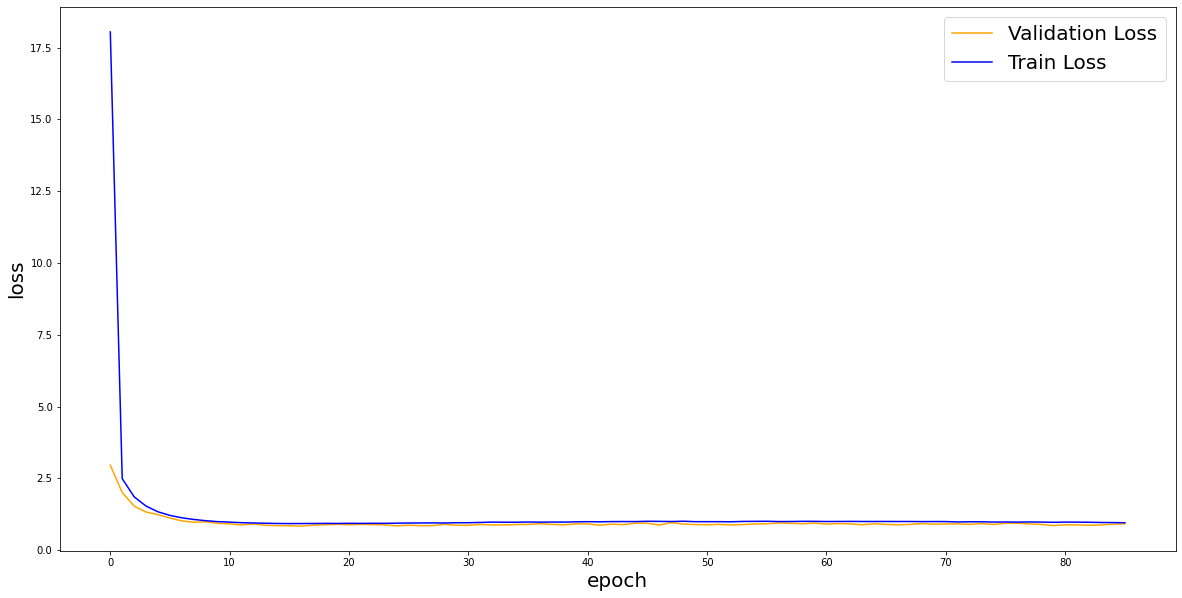

In [11]:
x_len = np.arange(len(valid_loss_list))
plt.figure(figsize=(20,10))
plt.plot(x_len, valid_loss_list, c='orange', label="Validation Loss")
plt.plot(x_len, train_loss_list, c='blue', label="Train Loss")
plt.xticks(np.arange(0, 90, 10))
#plt.title('With pretraining', fontsize=20)
plt.legend(loc='upper right')
plt.legend(loc='best', ncol=1, fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

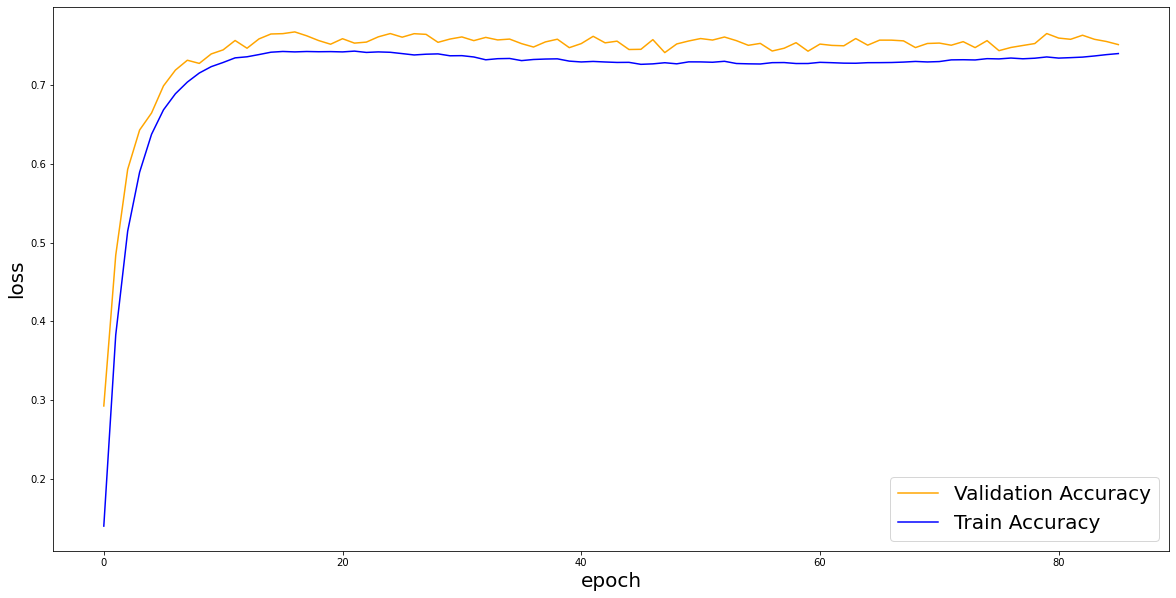

In [13]:
x_len = np.arange(len(valid_acc_list))
plt.figure(figsize=(20,10))
plt.plot(x_len, valid_acc_list, c='orange', label="Validation Accuracy")
plt.plot(x_len, train_acc_list, c='blue', label="Train Accuracy")
#plt.title('With pretraining', fontsize=20)
plt.legend(loc='upper right')
plt.legend(loc='best', ncol=1, fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()